# Introduction to Spatial Graphs in libpysal

The `Graph` class provides a modern, flexible representation of spatial relationships in libpysal.  
Introduced in 2023, it is designed to replace the legacy `weights.W` class with a more efficient, pandas-friendly structure based on adjacency lists.

Key advantages include:
- Immutable design for safer workflows
- Native integration with pandas (adjacency as a Series)
- Built-in support for visualization and transformations
- Better performance for large datasets

This notebook demonstrates the basics using the built-in Columbus dataset: building a contiguity graph, inspecting it, and applying static and interactive visualization.

***

### Imports and Data Loading

This section imports the required libraries and loads the Columbus dataset, a classic built-in example from libpysal containing 49 neighborhoods with crime and housing data.

- `geopandas`: Handles geospatial data as GeoDataFrames (tables with geometry).
- `libpysal.examples`: Provides access to built-in datasets.
- `libpysal.graph`: Contains the modern `Graph` class.
- `matplotlib.pyplot`: Used for static plotting later.

We also set a coordinate reference system (CRS) to EPSG:4326 (WGS84) for correct map rendering, as the original dataset lacks projection information.

In [2]:
import geopandas as gpd
from libpysal import examples, graph
import matplotlib.pyplot as plt

gdf = gpd.read_file(examples.get_path("columbus.shp"))
gdf = gdf.set_crs(epsg=4326, allow_override=True)

print("First 3 neighborhoods:")
print(gdf.head(3))

print("\nTotal neighborhoods:", len(gdf))

First 3 neighborhoods:
       AREA  PERIMETER  COLUMBUS_  COLUMBUS_I  POLYID  NEIG      HOVAL  \
0  0.309441   2.440629          2           5       1     5  80.467003   
1  0.259329   2.236939          3           1       2     1  44.567001   
2  0.192468   2.187547          4           6       3     6  26.350000   

      INC      CRIME      OPEN  ...  DISCBD          X          Y  NSA  NSB  \
0  19.531  15.725980  2.850747  ...    5.03  38.799999  44.070000  1.0  1.0   
1  21.232  18.801754  5.296720  ...    4.27  35.619999  42.380001  1.0  1.0   
2  15.956  30.626781  4.534649  ...    3.89  39.820000  41.180000  1.0  1.0   

    EW   CP   THOUS  NEIGNO                                           geometry  
0  1.0  0.0  1000.0  1005.0  POLYGON ((8.62413 14.23698, 8.5597 14.74245, 8...  
1  0.0  0.0  1000.0  1001.0  POLYGON ((8.25279 14.23694, 8.28276 14.22994, ...  
2  1.0  0.0  1000.0  1006.0  POLYGON ((8.65331 14.00809, 8.81814 14.00205, ...  

[3 rows x 21 columns]

Total neighborh

***
### Building a Queen Contiguity Graph

In spatial analysis, contiguity describes the neighbor relationships between geographic areas based on how their boundaries interact. Two standard definitions are commonly used:

- Rook contiguity - Areas are considered neighbors only if they share a full edge.
- Queen contiguity - Areas are considered neighbors if they share either an edge or a vertex.

Because Queen contiguity allows vertex-based connections, it typically creates more connections. This makes it one of the most widely used contiguity definitions in spatial analytics, especially when working with polygonal data.

In the current Graph API within libpysal, Queen contiguity can be obtained by setting rook=False. (By default, the parameter rook=True produces Rook contiguity.) This is the recommended approach for constructing contiguity graphs using modern libpysal.

In [3]:
from libpysal.graph import Graph

g_queen = Graph.build_contiguity(gdf, rook=False)

print("Queen Graph summary:")
print(f"  Number of neighborhoods (nodes): {g_queen.n}")
print(f"  Number of neighbor connections (edges): {g_queen.n_edges}")
print(f"  Average number of neighbors per neighborhood: {2 * g_queen.n_edges / g_queen.n:.1f}")

print("\nNeighbors of neighborhood 0:")
print(g_queen[0])

Queen Graph summary:
  Number of neighborhoods (nodes): 49
  Number of neighbor connections (edges): 236
  Average number of neighbors per neighborhood: 9.6

Neighbors of neighborhood 0:
neighbor
1    1
2    1
Name: weight, dtype: int64


### Geovisualization of the Queen Graph

Here we create a static map showing:
- Neighborhood polygons filled in light gray
- Red lines connecting centroids of neighboring neighborhoods

This gives a clear view of the spatial connections created by Queen contiguity.

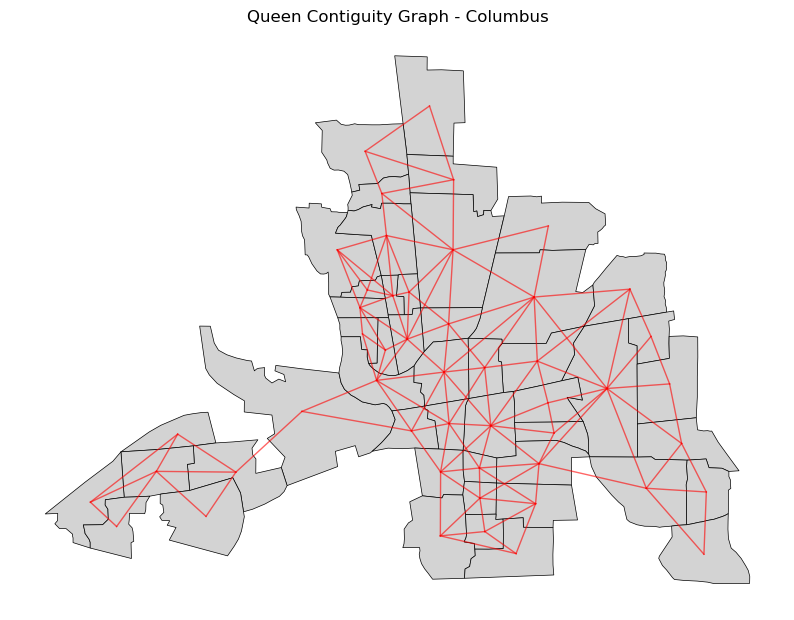

In [4]:
gdf = gdf.to_crs(epsg=3857)
centroids = gdf.geometry.centroid

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5)

for (i, j) in g_queen.adjacency.index:
    if j > i:
        ax.plot(
            [centroids[i].x, centroids[j].x],
            [centroids[i].y, centroids[j].y],
            color="red", linewidth=1, alpha=0.6,
        )

ax.set_title("Queen Contiguity Graph - Columbus")
ax.set_axis_off()
plt.show()


Here `Graph` adds an `explore` function allowing for a richer visualization:

In [5]:
m = gdf.explore()
g_queen.explore(gdf, m=m)
m
